In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Load packages and data

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import geopandas as gpd
import seaborn as sns
import re
import networkx as nx
from networkx.algorithms.community import greedy_modularity_communities
from networkx.algorithms.community.quality import modularity
import numpy as np
from itertools import permutations
from networkx.exception import NetworkXNoPath
from matplotlib.lines import Line2D
import matplotlib.cm as cm
import matplotlib.colors as mcolors

%matplotlib inline

In [3]:
# london_flows = pd.read_csv("/content/drive/MyDrive/UCL/Urban Simulation/Assessment/london_flows.csv")

# Loading the london graph with lengths and flows from practical week 10
G = nx.read_graphml('/content/drive/MyDrive/UCL/Urban Simulation/Assessment/london.graph')
stations = gpd.read_file('/content/drive/MyDrive/UCL/Urban Simulation/week10/data/tfl_stations.json')

In [4]:
#clean station names
station_names = {row.id: row['name'] for i, row in stations.iterrows()}
for k, v in station_names.items():
    if k == 'none':
        continue
    cleaned_name = re.sub('\sLU\s?|\sLO\s?|\sNR\s?|\sTf[lL]\s?|\sDLR\s?|\s\(.*\)', '', v)

    #note that bank and monument are enconded as one station in our TFL data, so we will do the same
    if cleaned_name in ['Bank', 'Monument']:
        cleaned_name = 'Bank and Monument'
    station_names[k] = cleaned_name

stations['name'] = stations['id'].apply(lambda x: station_names[x])

{'Piccadilly', 'Central', 'Northern', 'Hammersmith & City', 'Jubilee', 'TfL Rail', 'Bakerloo', 'Waterloo & City', 'Metropolitan', 'Circle', 'District', 'DLR', 'London Overground', 'Victoria'}


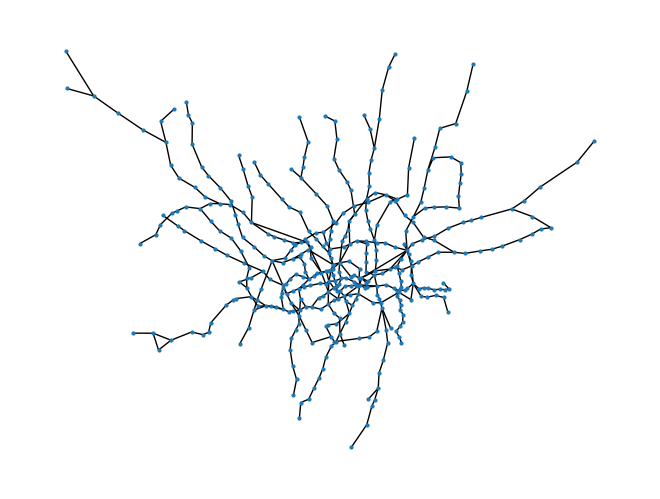

In [5]:
pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
Gcc = nx.connected_components(G)
for n in Gcc:
    G_sub = G.subgraph(n)
    lines = [data['line_name'] for u,v, data in G_sub.edges(data=True)]
    print(set(lines))
    nx.draw(G_sub, pos, node_size=4)
    plt.show()

# Centrality measures

## Closeness Centrality

In [6]:
G_clos_cen = nx.closeness_centrality(G)
df_clos_cen = pd.DataFrame.from_dict(G_clos_cen, columns=['closeness'], orient='index')
df_clos_cen = df_clos_cen.sort_values(by='closeness', ascending=False)

df_clos_top20 = df_clos_cen.head(20)
df_clos_cen.head(10)

,closeness
Green Park,0.114778
Bank and Monument,0.113572
King's Cross St. Pancras,0.113443
Westminster,0.112549
Waterloo,0.112265
Oxford Circus,0.111204
Bond Street,0.110988
Farringdon,0.110742
Angel,0.110742
Moorgate,0.110314


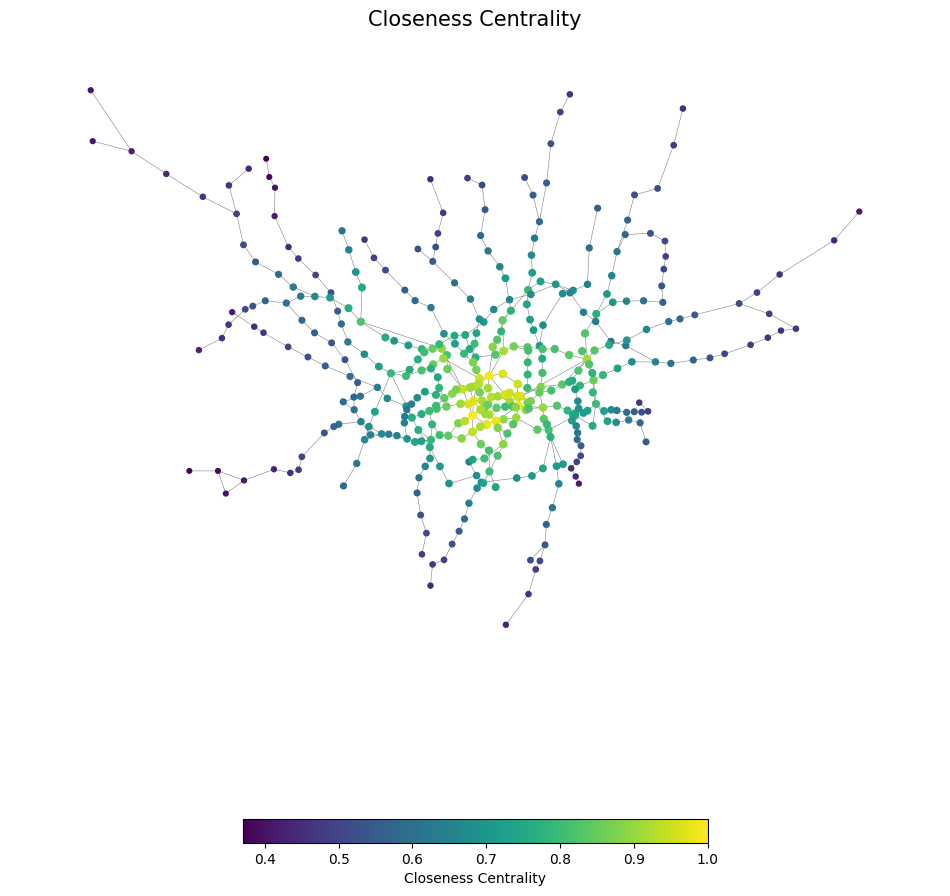

In [7]:
nx.set_node_attributes(G, G_clos_cen, 'closeness')
closeness_values=[(i[1]['closeness']) for i in G.nodes(data=True)]

clos_color=[(i[1]['closeness']/max(closeness_values)) for i in G.nodes(data=True)]
clos_size=[(i[1]['closeness']/max(closeness_values)*30) for i in G.nodes(data=True)]

fig, ax = plt.subplots(figsize=(12,12))

pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}
nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= clos_color,
        node_size= clos_size)

plt.colorbar(nod,label="Closeness Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Closeness Centrality",fontsize=15)
plt.show()

## Betweenness Centrality

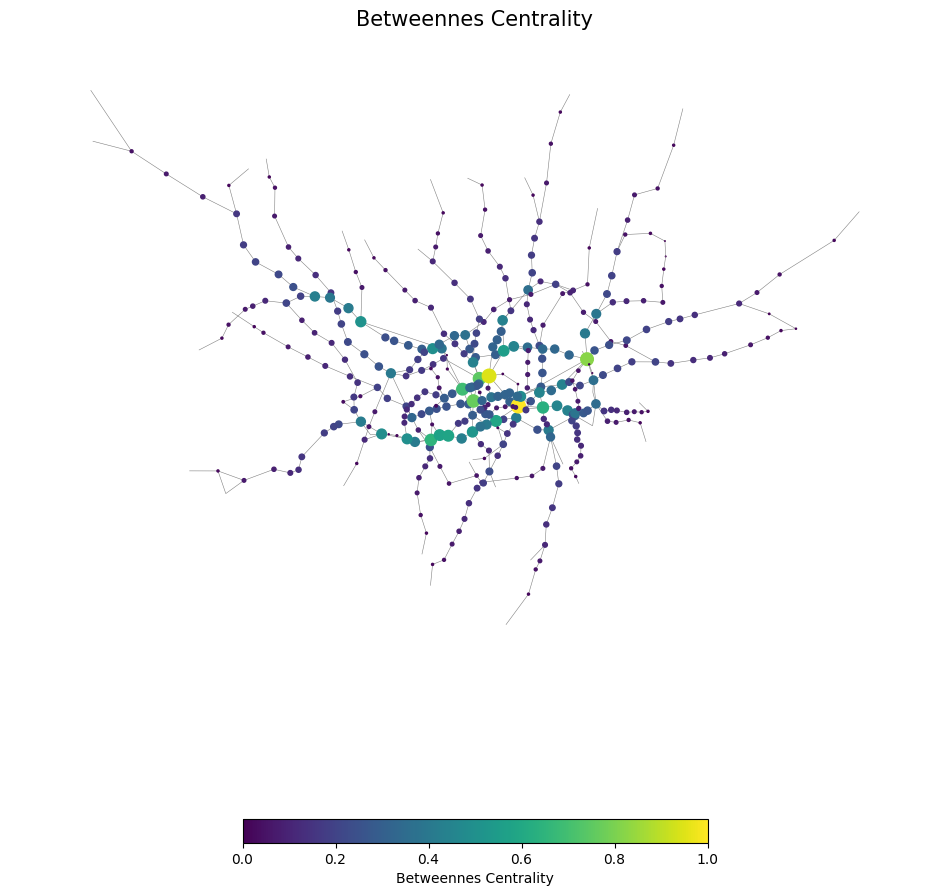

,betweenness
Bank and Monument,0.221253
King's Cross St. Pancras,0.209185
Stratford,0.182306
Oxford Circus,0.169937
Euston,0.165915
Baker Street,0.152256
Earl's Court,0.143797
Shadwell,0.139449
Waterloo,0.130426
South Kensington,0.129511


In [8]:
G_betwn_cen = nx.betweenness_centrality(G, weight='length', normalized=True)
df_betwn_cen = pd.DataFrame.from_dict(G_betwn_cen, columns=['betweenness'], orient='index')
df_betwn_cen_sorted = df_betwn_cen.sort_values(by='betweenness', ascending=False)
df_betwn_top20 = df_betwn_cen_sorted.head(20)

nx.set_node_attributes(G, G_betwn_cen, 'betweenness')
betweenness_values=[(i[1]['betweenness']) for i in G.nodes(data=True)]

bet_color=[(i[1]['betweenness']/max(betweenness_values)) for i in G.nodes(data=True)]
bet_size=[(i[1]['betweenness']/max(betweenness_values)*100) for i in G.nodes(data=True)]

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= bet_color,
        node_size= bet_size)

plt.colorbar(nod,label="Betweennes Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Betweennes Centrality",fontsize=15)
plt.show()
df_betwn_cen_sorted.head(10)

## Eigenvector centrality

In [9]:
G_eignv_cen = nx.eigenvector_centrality(G, max_iter=10000)
df_eignv_cen = pd.DataFrame.from_dict(G_eignv_cen, columns=['eigenvector'], orient='index')
df_eignv_cen = df_eignv_cen.sort_values(by='eigenvector', ascending=False)

df_eignv_top20 = df_eignv_cen.head(20)
df_eignv_cen.head(10)

,eigenvector
Bank and Monument,0.383427
Liverpool Street,0.328824
Stratford,0.269179
Waterloo,0.249731
Moorgate,0.215137
Green Park,0.197630
Oxford Circus,0.184094
Tower Hill,0.171676
Westminster,0.168610
Shadwell,0.159090


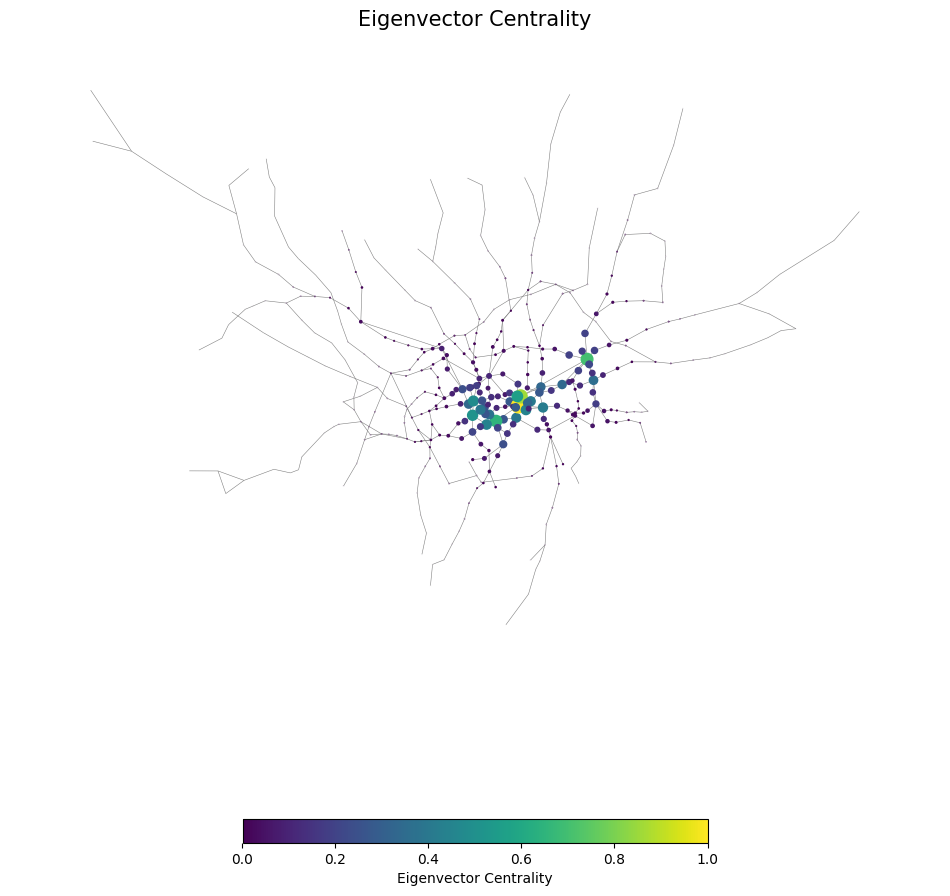

In [10]:
nx.set_node_attributes(G, G_eignv_cen, 'eigenvector')
eigenvector_values=[(i[1]['eigenvector']) for i in G.nodes(data=True)]
eig_color=[(i[1]['eigenvector']/max(eigenvector_values)) for i in G.nodes(data=True)]
eig_size=[(i[1]['eigenvector']/max(eigenvector_values)*100) for i in G.nodes(data=True)]

fig, ax = plt.subplots(figsize=(12,12))

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= eig_color,
        node_size= eig_size)

plt.colorbar(nod,label="Eigenvector Centrality",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Eigenvector Centrality",fontsize=15)
plt.show()

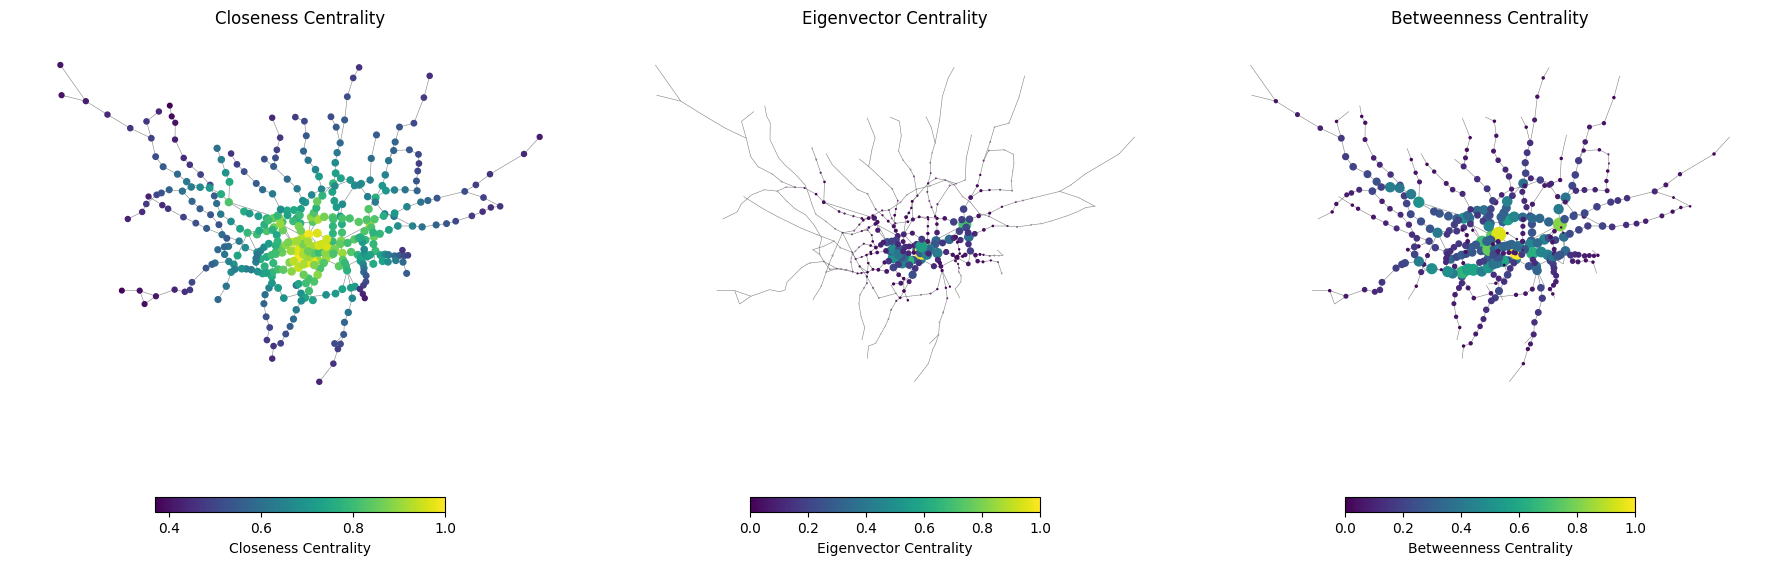

In [11]:
# Plot 1: Closeness Centrality
nx.set_node_attributes(G, G_clos_cen, 'closeness')
closeness_values = [i[1]['closeness'] for i in G.nodes(data=True)]
clos_color = [i[1]['closeness'] / max(closeness_values) for i in G.nodes(data=True)]
clos_size = [i[1]['closeness'] / max(closeness_values) * 30 for i in G.nodes(data=True)]

# Plot 2: Betweenness Centrality
nx.set_node_attributes(G, G_betwn_cen, 'betweenness')
betweenness_values = [i[1]['betweenness'] for i in G.nodes(data=True)]
bet_color = [i[1]['betweenness'] / max(betweenness_values) for i in G.nodes(data=True)]
bet_size = [i[1]['betweenness'] / max(betweenness_values) * 100 for i in G.nodes(data=True)]

# Plot 3: Eigenvector Centrality
nx.set_node_attributes(G, G_eignv_cen, 'eigenvector')
eigenvector_values = [i[1]['eigenvector'] for i in G.nodes(data=True)]
eig_color = [i[1]['eigenvector'] / max(eigenvector_values) for i in G.nodes(data=True)]
eig_size = [i[1]['eigenvector'] / max(eigenvector_values) * 100 for i in G.nodes(data=True)]

# Create subplots
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))

# Plot 1: Closeness Centrality
ax = axes[0]
ax.set_title("Closeness Centrality")
nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=0.4)
nod = nx.draw_networkx_nodes(G, pos=pos, node_color=clos_color, node_size=clos_size, ax=ax)
plt.colorbar(nod, ax=ax, label="Closeness Centrality", orientation="horizontal", shrink=0.5)
ax.axis("off")


# Plot 2: Eigenvector Centrality
ax = axes[1]
ax.set_title("Eigenvector Centrality")
nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=0.4)
nod = nx.draw_networkx_nodes(G, pos=pos, node_color=eig_color, node_size=eig_size, ax=ax)
plt.colorbar(nod, ax=ax, label="Eigenvector Centrality", orientation="horizontal", shrink=0.5)
ax.axis("off")

# Plot 3: Betweenness Centrality
ax = axes[2]
ax.set_title("Betweenness Centrality")
nx.draw_networkx_edges(G, pos, ax=ax, edge_color='gray', width=0.4)
nod = nx.draw_networkx_nodes(G, pos=pos, node_color=bet_color, node_size=bet_size, ax=ax)
plt.colorbar(nod, ax=ax, label="Betweenness Centrality", orientation="horizontal", shrink=0.5)
ax.axis("off")

plt.tight_layout()

plt.savefig('centralities_maps.png', dpi=300)
plt.show()

## Plot the top stations across centrality measures

ChatGPT was used for the code in the cell below

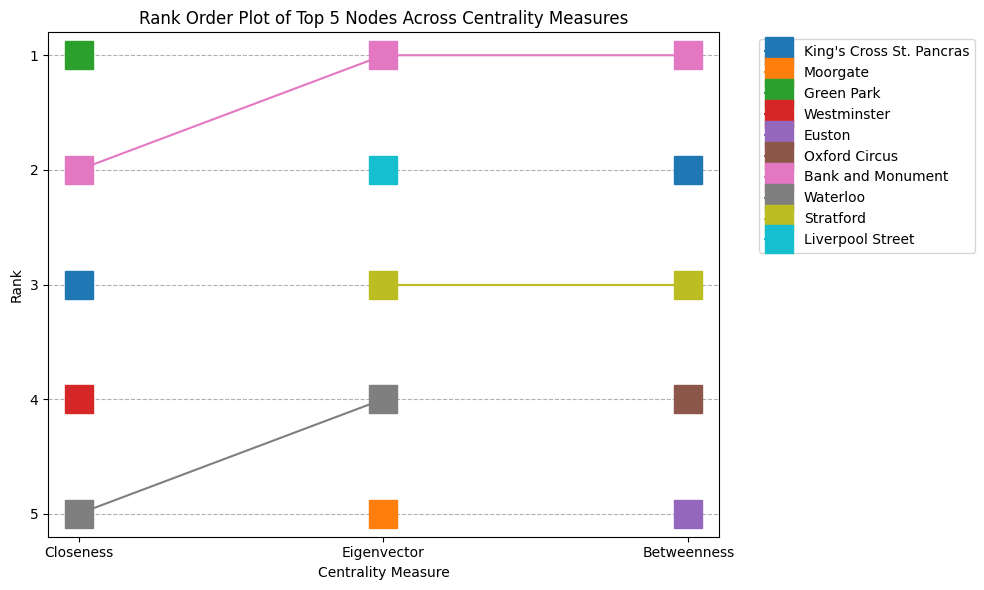

In [12]:
# Take the top 5 nodes from each centrality measure
top_nodes_clos = list(df_clos_top20.index)[:5]
top_nodes_betwn = list(df_betwn_top20.index)[:5]
top_nodes_eignv = list(df_eignv_top20.index)[:5]

# Combine all top nodes
top_nodes_combined = set(top_nodes_clos + top_nodes_eignv + top_nodes_betwn)

# Create a dictionary to store the ranks of each node for each centrality measure
node_ranks = {node: [None, None, None] for node in top_nodes_combined}

# Assign ranks
for i, node in enumerate(top_nodes_clos):
    node_ranks[node][0] = i + 1

for i, node in enumerate(top_nodes_eignv):
    node_ranks[node][1] = i + 1

for i, node in enumerate(top_nodes_betwn):
    node_ranks[node][2] = i + 1

# Create the plot
plt.figure(figsize=(10, 6))
for node, ranks in node_ranks.items():
    plt.plot([0, 1, 2], ranks, marker='s', markersize=20, label=node)

plt.xticks([0, 1, 2], ['Closeness', 'Eigenvector', 'Betweenness'])  # Change order here
plt.xlabel('Centrality Measure')
plt.ylabel('Rank')
plt.title('Rank Order Plot of Top 5 Nodes Across Centrality Measures')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')

# Set y-axis ticks to be discrete numbers
plt.yticks(range(1, 6))

# Adjust grid lines
plt.grid(axis='y', linestyle='--')
plt.gca().invert_yaxis()  # Invert y-axis
plt.tight_layout()

plt.savefig('topstations_3centrality.png', dpi=300)
plt.show()

# Impact Measures

In [13]:


# The average of the shortest paths for all pairs of nodes
avg_path_length = nx.average_shortest_path_length(G, weight="length")
print("Average Path Length of the network:", avg_path_length)

Average Path Length of the network: 20099.72157291416


In [14]:
print(f"The global efficiency of the network: {nx.global_efficiency(G)}")

The global efficiency of the network: 0.1012561935972123


In [15]:
# # Calculate connectance or density
# num_nodes = len(G.nodes)
# num_edges = len(G.edges)
# density = (2 * num_edges) / (num_nodes * (num_nodes - 1))

# print("Connectance or Density (ρ):", density)


# Node Removal

In [16]:
# function to calculatye impact measures from a graph G
def evaluate_impact(G):
  if not nx.is_connected(G):
    connected_components = list(nx.connected_components(G))
    avg_path_lengths = []
    for component in connected_components:
      subgraph = G.subgraph(component)
      avg_path_length = nx.average_shortest_path_length(subgraph, weight="length")
      avg_path_lengths.append(avg_path_length)
      avg_path_length = sum(avg_path_lengths) / len(avg_path_lengths)
  else:
    avg_path_length = nx.average_shortest_path_length(G, weight="length")

  global_eff = nx.global_efficiency(G)

  return avg_path_length, global_eff

## For closeness centrality

In [17]:
### non-sequential node removal ###

# Initialise dataframe to store results
columns = ['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure']
clos_nonseq_df = pd.DataFrame(columns=columns)

G_nonseq = G.copy()

base_avg_path_length, base_global_eff = evaluate_impact(G_nonseq)

clos_nonseq_df.loc[0] = [0, 'NA', base_avg_path_length, base_global_eff, 'non-sequential', 'closeness']

for i in range(20):
    removed_node = df_clos_top20.index[i]
    G_nonseq.remove_node(removed_node)
    avg_path_length, global_eff = evaluate_impact(G_nonseq)

    clos_nonseq_df.loc[i+1] = [i+1, removed_node, avg_path_length, global_eff, 'non-sequential', 'closeness']

### sequential node removal ###
columns = ['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure']
clos_seq_df = pd.DataFrame(columns=columns)
clos_seq_df.loc[0] = [0, 'NA', base_avg_path_length, base_global_eff, 'sequential', 'closeness']

df_clos_cen = pd.DataFrame.from_dict(G_clos_cen, columns=['closeness'], orient='index')
df_clos_cen = df_clos_cen.sort_values(by='closeness', ascending=False)

G_seq = G.copy()

for i in range(20):
  G_clos_cen = nx.closeness_centrality(G_seq)
  nx.set_node_attributes(G_seq, G_clos_cen, 'closeness')

  df = pd.DataFrame(index=G_seq.nodes())
  df['closeness'] = pd.Series(nx.get_node_attributes(G_seq, 'closeness'))
  df_sorted = df.sort_values(['closeness'], ascending=False)
  row = df_sorted.head(1)
  removed_station = row.index[0]
  G_seq.remove_node(removed_station)

  avg_path_length, global_eff = evaluate_impact(G_seq)

  new_row = pd.DataFrame([[i+1, removed_station, avg_path_length, global_eff, 'sequential', 'closeness']], columns=['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure'])
  clos_seq_df = pd.concat([clos_seq_df, new_row], ignore_index=True)

clos_seq_df.head(5)

,nodesRemoved,stationRemoved,AvgPathLength,GlobalEfficiency,Method,CentralityMeasure
0,0,NA,20099.721573,0.101256,sequential,closeness
1,1,Green Park,20208.704540,0.099190,sequential,closeness
2,2,King's Cross St. Pancras,20761.663553,0.094435,sequential,closeness
3,3,Waterloo,20912.819496,0.091816,sequential,closeness
4,4,Bank and Monument,23087.194400,0.085426,sequential,closeness


## For betweenness centrality

In [18]:
### non-sequential node removal ###
# Initialise dataframe to store results
columns = ['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure']
betw_nonseq_df = pd.DataFrame(columns=columns)

G_nonseq = G.copy()

base_avg_path_length, base_global_eff = evaluate_impact(G_nonseq)
betw_nonseq_df.loc[0] = [0, 'NA', base_avg_path_length, base_global_eff, 'non-sequential', 'betweenness']

for i in range(20):
    removed_node = df_betwn_top20.index[i]
    G_nonseq.remove_node(removed_node)
    avg_path_length, global_eff = evaluate_impact(G_nonseq)

    betw_nonseq_df.loc[i+1] = [i+1, removed_node, avg_path_length, global_eff, 'non-sequential', 'betweenness']

### sequential node removal ###
columns = ['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure']
betw_seq_df = pd.DataFrame(columns=columns)
betw_seq_df.loc[0] = [0, 'NA', base_avg_path_length, base_global_eff, 'sequential', 'betweenness']

df_betw_cen = pd.DataFrame.from_dict(G_betwn_cen, columns=['betweenness'], orient='index')
df_betw_cen = df_betw_cen.sort_values(by='betweenness', ascending=False)

G_seq = G.copy()

for i in range(20):
  G_betwn_cen = nx.betweenness_centrality(G_seq, weight='length', normalized=True)
  nx.set_node_attributes(G_seq, G_betwn_cen, 'betweenness')

  df = pd.DataFrame(index=G_seq.nodes())
  df['betweenness'] = pd.Series(nx.get_node_attributes(G_seq, 'betweenness'))
  df_sorted = df.sort_values(['betweenness'], ascending=False)
  row = df_sorted.head(1)
  removed_station = row.index[0]
  G_seq.remove_node(removed_station)

  avg_path_length, global_eff = evaluate_impact(G_seq)

  new_row = pd.DataFrame([[i+1, removed_station, avg_path_length, global_eff, 'sequential', 'betweenness']], columns=['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure'])
  betw_seq_df = pd.concat([betw_seq_df, new_row], ignore_index=True)

betw_seq_df.head(10)

,nodesRemoved,stationRemoved,AvgPathLength,GlobalEfficiency,Method,CentralityMeasure
0,0,NA,20099.721573,0.101256,sequential,betweenness
1,1,Bank and Monument,20423.399394,0.096735,sequential,betweenness
2,2,King's Cross St. Pancras,21621.656723,0.089883,sequential,betweenness
3,3,Canada Water,25212.677947,0.083058,sequential,betweenness
4,4,West Hampstead,17617.421029,0.060240,sequential,betweenness
5,5,Earl's Court,18129.009165,0.058734,sequential,betweenness
6,6,Oxford Circus,18381.367498,0.057682,sequential,betweenness
7,7,Shepherd's Bush,16518.452184,0.051808,sequential,betweenness
8,8,Baker Street,10729.035580,0.048191,sequential,betweenness
9,9,Acton Town,9933.374064,0.042189,sequential,betweenness


## For eigenvector centrality

In [19]:
### non-sequential node removal ###
# Initialise dataframe to store results
columns = ['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure']
eig_nonseq_df = pd.DataFrame(columns=columns)

G_nonseq = G.copy()

base_avg_path_length, base_global_eff = evaluate_impact(G_nonseq)
eig_nonseq_df.loc[0] = [0, 'NA', base_avg_path_length, base_global_eff, 'non-sequential', 'eigenvector']

for i in range(20):
    removed_node = df_eignv_top20.index[i]
    G_nonseq.remove_node(removed_node)
    avg_path_length, global_eff = evaluate_impact(G_nonseq)

    eig_nonseq_df.loc[i+1] = [i+1, removed_node, avg_path_length, global_eff, 'non-sequential', 'eigenvector']

### sequential node removal ###
columns = ['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure']
eig_seq_df = pd.DataFrame(columns=columns)
eig_seq_df.loc[0] = [0, 'NA', base_avg_path_length, base_global_eff, 'sequential', 'eigenvector']

df_eig_cen = pd.DataFrame.from_dict(G_eignv_cen, columns=['eigenvector'], orient='index')
df_eig_cen = df_eig_cen.sort_values(by='eigenvector', ascending=False)

G_seq = G.copy()

for i in range(20):
  G_eig_cen = nx.eigenvector_centrality(G_seq, max_iter=10000)
  nx.set_node_attributes(G_seq, G_eig_cen, 'eigenvector')

  df = pd.DataFrame(index=G_seq.nodes())
  df['eigenvector'] = pd.Series(nx.get_node_attributes(G_seq, 'eigenvector'))
  df_sorted = df.sort_values(['eigenvector'], ascending=False)
  row = df_sorted.head(1)
  removed_station = row.index[0]
  G_seq.remove_node(removed_station)

  avg_path_length, global_eff = evaluate_impact(G_seq)

  new_row = pd.DataFrame([[i+1, removed_station, avg_path_length, global_eff, 'sequential', 'eigenvector']], columns=['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure'])
  eig_seq_df = pd.concat([eig_seq_df, new_row], ignore_index=True)

eig_seq_df.head(5)

,nodesRemoved,stationRemoved,AvgPathLength,GlobalEfficiency,Method,CentralityMeasure
0,0,NA,20099.721573,0.101256,sequential,eigenvector
1,1,Bank and Monument,20423.399394,0.096735,sequential,eigenvector
2,2,Oxford Circus,20546.922999,0.095722,sequential,eigenvector
3,3,Stratford,9793.770455,0.084813,sequential,eigenvector
4,4,Earl's Court,9930.992538,0.083369,sequential,eigenvector


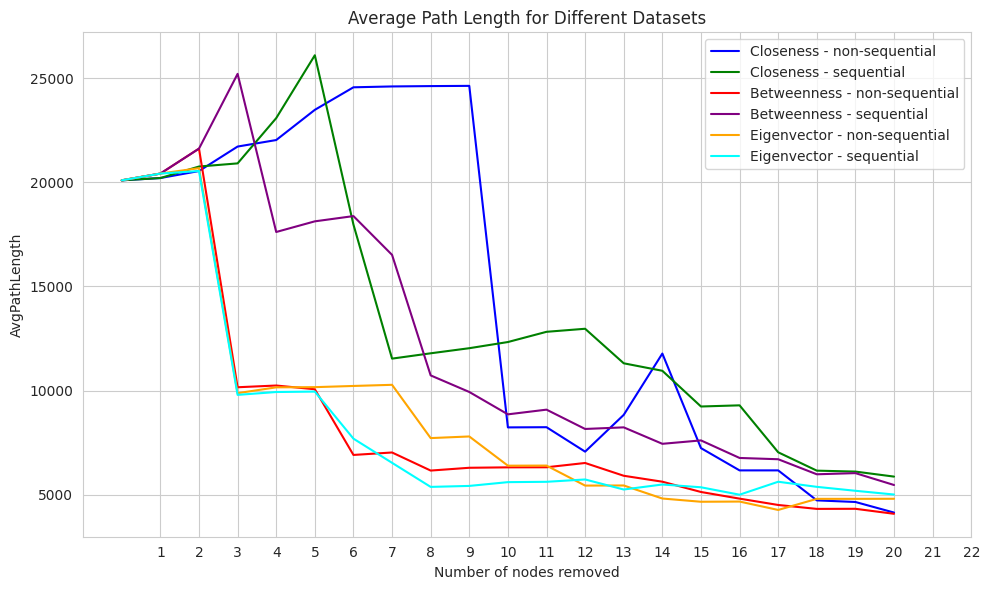

In [20]:
sns.set_style("whitegrid")
dataframes = [clos_nonseq_df, clos_seq_df, betw_nonseq_df, betw_seq_df, eig_nonseq_df, eig_seq_df]

colors = ['blue', 'green', 'red', 'purple', 'orange', 'cyan']
labels = ['Closeness', 'Closeness', 'Betweenness', 'Betweenness', 'Eigenvector', 'Eigenvector']

# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

for i, df in enumerate(dataframes):
    plt.plot(df.index, df['AvgPathLength'], label=labels[i] + ' - ' + df['Method'].iloc[0], color=colors[i])

plt.xlabel('Number of nodes removed')
plt.ylabel('AvgPathLength')
plt.title('Average Path Length for Different Datasets')
plt.legend()
plt.xticks(range(1, 23))
plt.tight_layout()
plt.show()

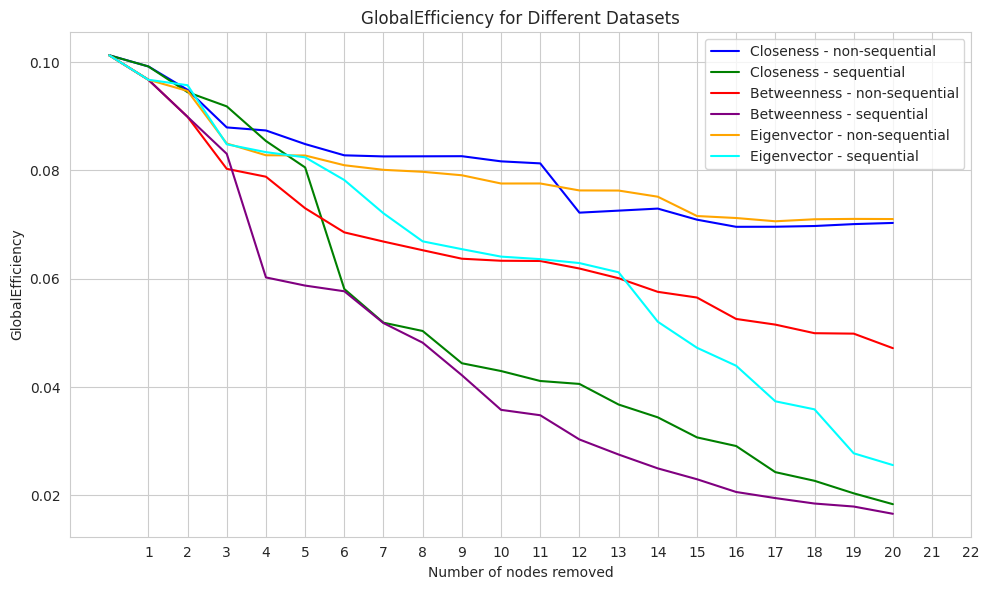

In [21]:
sns.set_style("whitegrid")
dataframes = [clos_nonseq_df, clos_seq_df, betw_nonseq_df, betw_seq_df, eig_nonseq_df, eig_seq_df]

# Plotting
plt.figure(figsize=(10, 6))  # Adjust size if needed

for i, df in enumerate(dataframes):
    plt.plot(df.index, df['GlobalEfficiency'], label=labels[i] + ' - ' + df['Method'].iloc[0], color=colors[i])

plt.xlabel('Number of nodes removed')
plt.ylabel('GlobalEfficiency')
plt.title('GlobalEfficiency for Different Datasets')
plt.legend()
plt.xticks(range(1, 23))
plt.tight_layout()
plt.show()

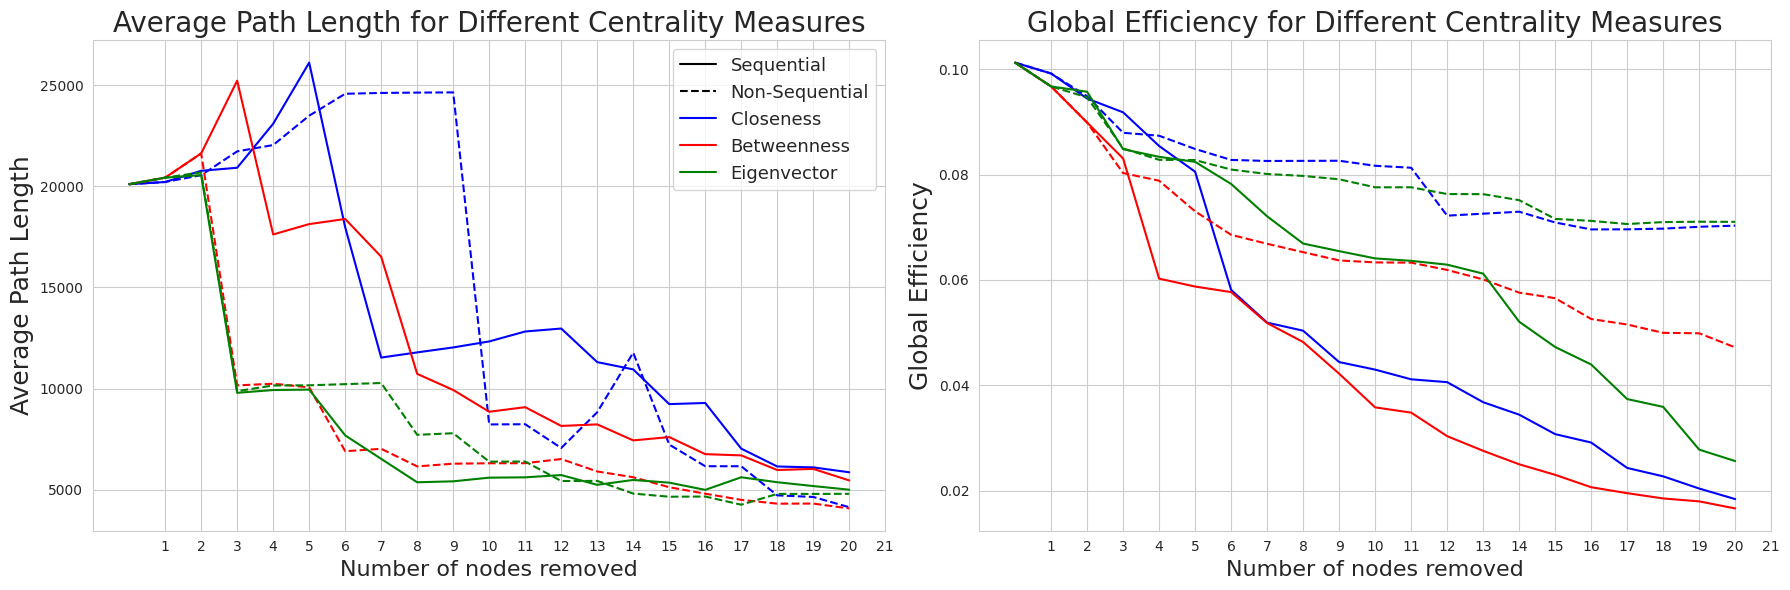

In [22]:
sns.set_style("whitegrid")

dataframes = [clos_nonseq_df, clos_seq_df, betw_nonseq_df, betw_seq_df, eig_nonseq_df, eig_seq_df]

# Define line styles
line_styles = ['--', '-', '--', '-', '--', '-']
colors = {'closeness': 'blue', 'betweenness': 'red', 'eigenvector': 'green'}

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))  # 1 row, 2 columns

legend_handles = []

# Plot 1: Average Path Length
plt.sca(axes[0])  # Set the current axis to the first subplot
for i, df in enumerate(dataframes):
    linestyle = line_styles[i] if 'seq' in df['Method'].iloc[0] else '-'
    color = colors[df['CentralityMeasure'].iloc[0].lower()]
    axes[0].plot(df.index, df['AvgPathLength'], linestyle=linestyle, color=color)

    # Add unique legend entries
    if i == 0:
        legend_handles.append(Line2D([0], [0], linestyle='-', color='black', label='Sequential'))
        legend_handles.append(Line2D([0], [0], linestyle='--', color='black', label='Non-Sequential'))

for centrality_measure, color in colors.items():
    legend_handles.append(Line2D([0], [0], linestyle='-', color=color, label=centrality_measure.capitalize()))

axes[0].set_xlabel('Number of nodes removed', fontsize=16)
axes[0].set_ylabel('Average Path Length', fontsize=18)
axes[0].set_title('Average Path Length for Different Centrality Measures', fontsize=20)
axes[0].legend(handles=legend_handles, fontsize=13)
axes[0].set_xticks(range(1, 22))

# Plot 2: Global Efficiency
plt.sca(axes[1])  # Set the current axis to the second subplot
for i, df in enumerate(dataframes):
    linestyle = line_styles[i] if 'seq' in df['Method'].iloc[0] else '-'
    color = colors[df['CentralityMeasure'].iloc[0].lower()]
    axes[1].plot(df.index, df['GlobalEfficiency'], linestyle=linestyle, color=color)

axes[1].set_xlabel('Number of nodes removed', fontsize=16)
axes[1].set_ylabel('Global Efficiency', fontsize=18)
axes[1].set_title('Global Efficiency for Different Centrality Measures', fontsize=20)
axes[1].set_xticks(range(1, 22))

plt.tight_layout()

# Adding a common legend to the first plot
axes[0].legend(handles=legend_handles, fontsize=13)

plt.savefig('impact_measures_nonflow.png', dpi=300)
plt.show()

# Flows - Weighted Network

In [23]:
london_OD_AMpeak = pd.read_csv("/content/drive/MyDrive/UCL/Urban Simulation/Assessment/flows_london_OD_AMpeak.csv")

## Assign the flows to the network as edge attribute considering the length of edges and number of transfers

# not very efficient and takes a while
# Create a dictionary to store flows for all edges
flows = {(u,v): 0 for u,v in G.edges()}

# Calculate shortest paths for all flows and add data to dict
for i, row in london_OD_AMpeak.iterrows():
    source = row.station_origin
    target = row.station_destination

    def custom_weight(u, v, d):
      path = nx.shortest_path(G, u, v, weight='length')

      length_of_edge = G.edges[u, v]['length']  # Get the length of the edge

      # Get line names of the starting and ending nodes
      start_line = G.edges[path[0], path[1]]['line_name']
      end_line = G.edges[path[-2], path[-1]]['line_name']

      # Count all unique line names between all nodes on the path
      unique_lines = set()
      for i in range(len(path)-1):
          edge = (path[i], path[i+1])
          if 'line_name' in G.edges[edge]:
              unique_lines.add(G.edges[edge]['line_name'])
      total_transfers = (len(unique_lines)-1)
      total_transfers_final = 0 if start_line == end_line else total_transfers

      # Prints below used for validating if the function works for selecting paths with fewer transfers
      # print("start with", start_line, " end with ", end_line, "total transfers: ", total_transfers)
      # print("Unique line names on the path:", unique_lines)

      return d.get('weight', 0) + length_of_edge + total_transfers * 1500

    # Get shortest path with custom weight function
    path = nx.dijkstra_path(G, source, target, weight=custom_weight)

    # Our path is a list of nodes, we need to turn this to a list of edges
    path_edges = list(zip(path, path[1:]))

    # Add flows to our dict
    for u, v in path_edges:
        try:
            flows[(u,v)] += row.flows
        except:
            flows[(v,u)] += row.flows

# Set this as a network attribute
nx.set_edge_attributes(G, flows, 'flows_corrected')

<ipython-input-24-65c33210e839>:16: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno')
<ipython-input-24-65c33210e839>:31: MatplotlibDeprecationWarning: Unable to determine Axes to steal space for Colorbar. Using gca(), but will raise in the future. Either provide the *cax* argument to use as the Axes for the Colorbar, provide the *ax* argument to steal space from it, or add *mappable* to an Axes.
  colorbar = plt.colorbar(sm, label="Passenger Flows", orientation="horizontal", shrink=0.5, pad=0)


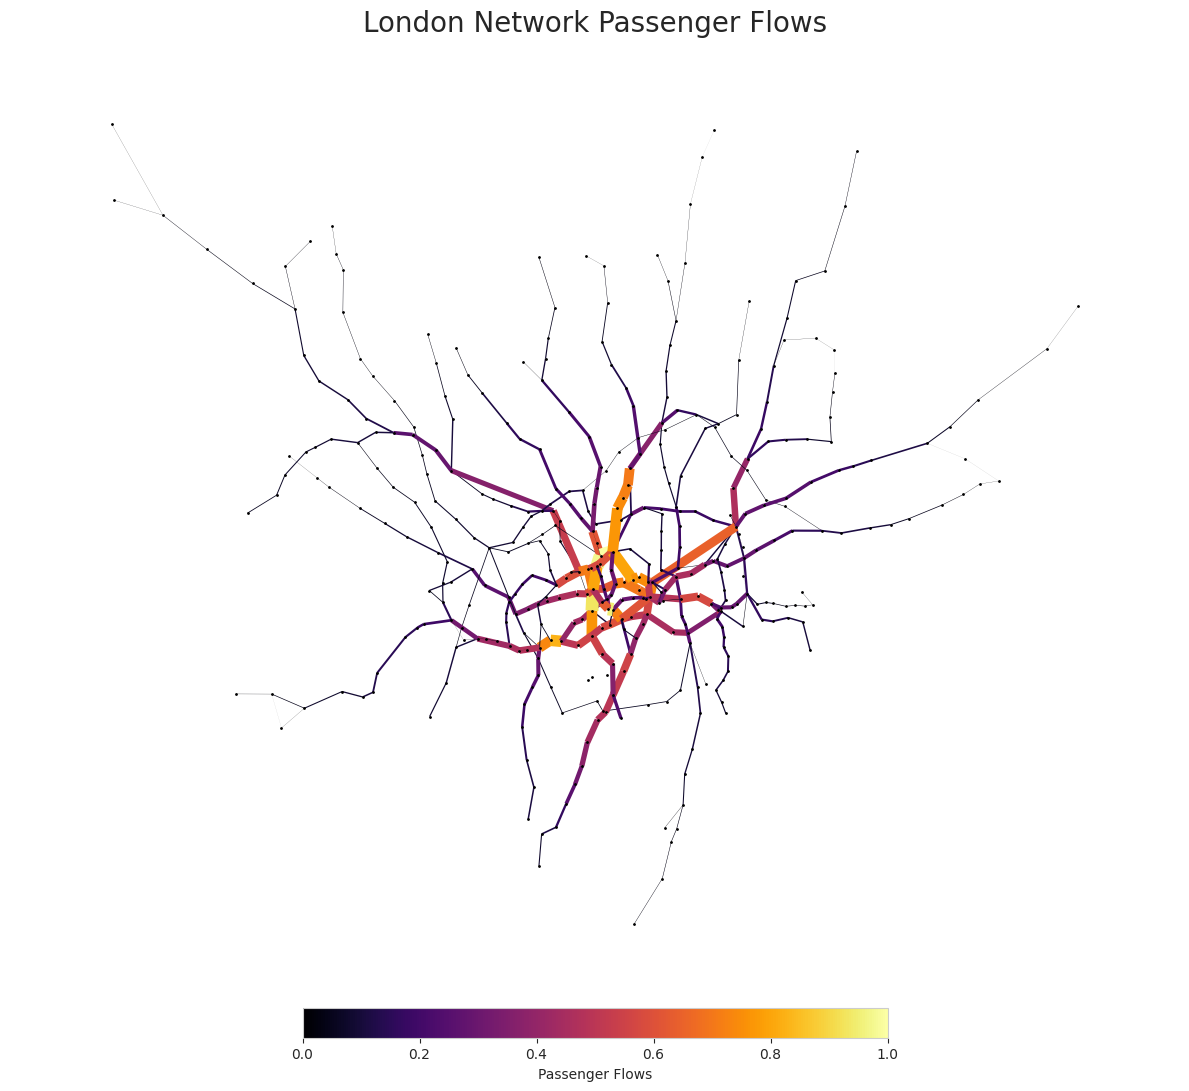

In [24]:
# show the flows
# invert weights
for source, target, att in G.edges(data=True):
    att['inv_flows'] =  1 / (att.get('flows_corrected', 0) + .001)

flows_values = [d['flows_corrected'] for u,v,d in G.edges(data=True)]

max_flow = max(flows_values)

flow_color = [d['flows_corrected']/max_flow for u,v,d in G.edges(data=True)]
flow_width = [d['flows_corrected']/max_flow * 10 for u,v,d in G.edges(data=True)]

pos = {row['name']: row.geometry.coords[0] for i, row in stations.iterrows() if row['name'] in G.nodes()}

fig, ax = plt.subplots(figsize=(12,12))
cmap = cm.get_cmap('inferno')

edge_colors = [cmap(color) for color in flow_color]

edg = nx.draw_networkx_edges(G, pos, edge_color=edge_colors, width=flow_width)

nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= 'black',
        node_size= 1)

# Create a ScalarMappable object for the colorbar
norm = mcolors.Normalize(vmin=min(flow_color), vmax=max(flow_color))
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
colorbar = plt.colorbar(sm, label="Passenger Flows", orientation="horizontal", shrink=0.5, pad=0)

plt.axis("off")
plt.title("London Network Passenger Flows", fontsize=20)
plt.tight_layout()
plt.savefig('flows.png', dpi=300)
plt.show()

## Centrality measure

<ipython-input-25-52801d4e4127>:18: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = cm.get_cmap('inferno')


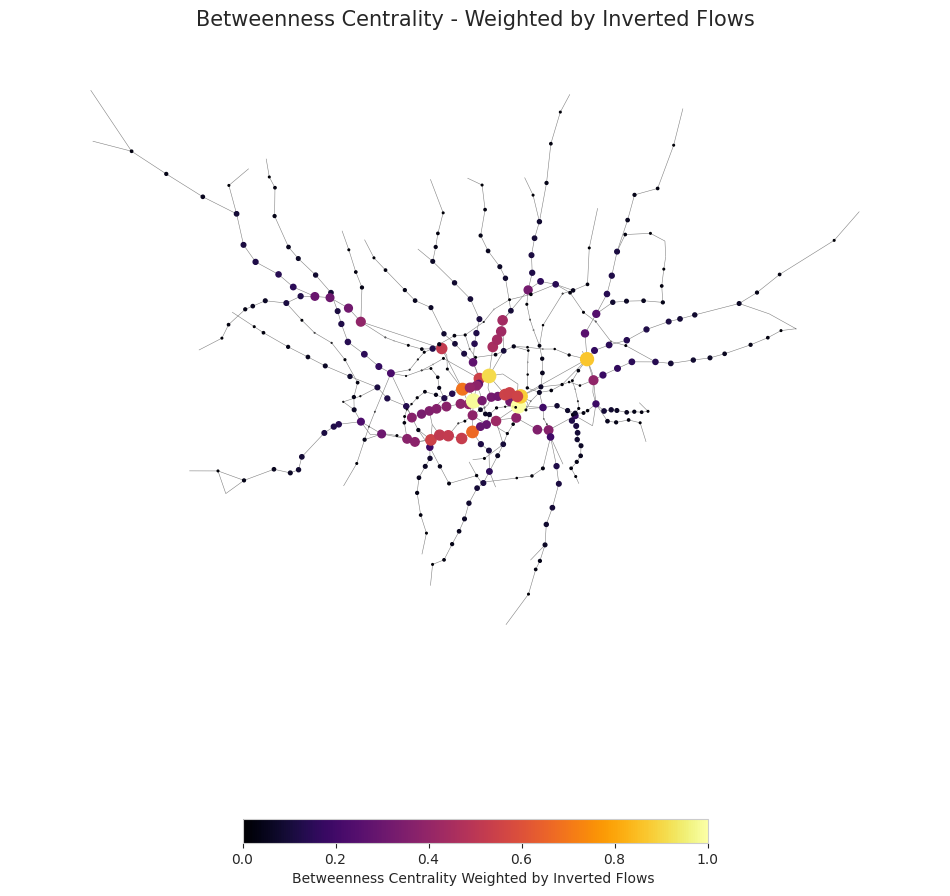

,betweenness
Bank and Monument,0.355213
Oxford Circus,0.350301
King's Cross St. Pancras,0.322055
Liverpool Street,0.313296
Stratford,0.307105
Baker Street,0.245551
Victoria,0.236454
Moorgate,0.196779
Earl's Court,0.195113
Farringdon,0.195100


In [25]:
# invert weights
for source, target, att in G.edges(data=True):
    att['inv_flows'] =  1 / (att.get('flows_corrected', 0) + .001)

G_betwn_flows_cen = nx.betweenness_centrality(G, weight='inv_flows', normalized=True)
df_betwn_flows_cen = pd.DataFrame.from_dict(G_betwn_flows_cen, columns=['betweenness'], orient='index')
df_betwn_flows_cen = df_betwn_flows_cen.sort_values(by='betweenness', ascending=False)
df_betwn_flows_top20 = df_betwn_flows_cen.head(20)

nx.set_node_attributes(G, G_betwn_flows_cen, 'betweenness_invflows')
betweenness_flows_values=[(i[1]['betweenness_invflows']) for i in G.nodes(data=True)]

btwinvflw_color=[(i[1]['betweenness_invflows']/max(betweenness_flows_values)) for i in G.nodes(data=True)]
btwinvflw_size=[(i[1]['betweenness_invflows']/max(betweenness_flows_values)*100) for i in G.nodes(data=True)]

fig, ax = plt.subplots(figsize=(12,12))

cmap = cm.get_cmap('inferno')

nx.draw_networkx_edges(G, pos,edge_color='gray', width=0.4)
nod=nx.draw_networkx_nodes(G,
        pos = pos,
        node_color= btwinvflw_color,
        node_size= btwinvflw_size,
                           cmap=cmap)

plt.colorbar(nod,label="Betweenness Centrality Weighted by Inverted Flows ",orientation="horizontal", shrink=0.5)
plt.axis("off")
plt.title("Betweenness Centrality - Weighted by Inverted Flows",fontsize=15)
plt.show()

df_betwn_flows_top20.head(10)

In [1]:
# First plot: Betweenness Centrality
G_betwn_cen = nx.betweenness_centrality(G, weight='length', normalized=True)
df_betwn_cen = pd.DataFrame.from_dict(G_betwn_cen, columns=['betweenness'], orient='index')
df_betwn_cen_sorted = df_betwn_cen.sort_values(by='betweenness', ascending=False)
df_betwn_length_top20 = df_betwn_cen_sorted.head(20)

nx.set_node_attributes(G, G_betwn_cen, 'betweenness')
betweenness_values = [(i[1]['betweenness']) for i in G.nodes(data=True)]

bet_color = [(i[1]['betweenness'] / max(betweenness_values)) for i in G.nodes(data=True)]
bet_size = [(i[1]['betweenness'] / max(betweenness_values) * 100) for i in G.nodes(data=True)]
cmap_vir = cm.get_cmap('viridis')

fig, axes = plt.subplots(1, 2, figsize=(18, 9))

# Plotting first graph
ax = axes[0]
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.4, ax=ax)
nod = nx.draw_networkx_nodes(G,
                              pos=pos,
                              node_color=bet_color,
                              node_size=bet_size,
                              ax=ax,
                             cmap=cmap
                             )
plt.colorbar(nod, label="Betweenness Centrality", orientation="horizontal", shrink=0.5, ax=ax)
ax.axis("off")
ax.set_title("Betweenness Centrality Length Weighted", fontsize=20)


# Second plot: Betweenness Centrality Weighted by Inverted Flows
G_betwn_flows_cen = nx.betweenness_centrality(G, weight='inv_flows', normalized=True)
df_betwn_flows_cen = pd.DataFrame.from_dict(G_betwn_flows_cen, columns=['betweenness'], orient='index')
df_betwn_flows_cen = df_betwn_flows_cen.sort_values(by='betweenness', ascending=False)
df_betwn_flows_top20 = df_betwn_flows_cen.head(20)

nx.set_node_attributes(G, G_betwn_flows_cen, 'betweenness_invflows')
betweenness_flows_values = [(i[1]['betweenness_invflows']) for i in G.nodes(data=True)]

btwinvflw_color = [(i[1]['betweenness_invflows'] / max(betweenness_flows_values)) for i in G.nodes(data=True)]
btwinvflw_size = [(i[1]['betweenness_invflows'] / max(betweenness_flows_values) * 100) for i in G.nodes(data=True)]

# Plotting second graph
ax = axes[1]
nx.draw_networkx_edges(G, pos, edge_color='gray', width=0.4, ax=ax)
nod = nx.draw_networkx_nodes(G,
                              pos=pos,
                              node_color=btwinvflw_color,
                              node_size=btwinvflw_size,
                              ax=ax,
                             cmap=cmap)
plt.colorbar(nod, label="Betweenness Centrality Weighted by Inverted Flows", orientation="horizontal", shrink=0.5, ax=ax)
ax.axis("off")
ax.set_title("Betweenness Centrality Flows Weighted", fontsize=20)

plt.savefig('betweenness_comparison_weighted.png', dpi=300)

plt.tight_layout()
plt.show()

NameError: name 'nx' is not defined

In [27]:
df_betwn_length_top20 = df_betwn_length_top20.reset_index()
df_betwn_length_top20 = df_betwn_length_top20.rename(columns={'index': 'Station'})

df_betwn_flows_top20 = df_betwn_flows_top20.reset_index()
df_betwn_flows_top20 = df_betwn_flows_top20.rename(columns={'index': 'Station'})

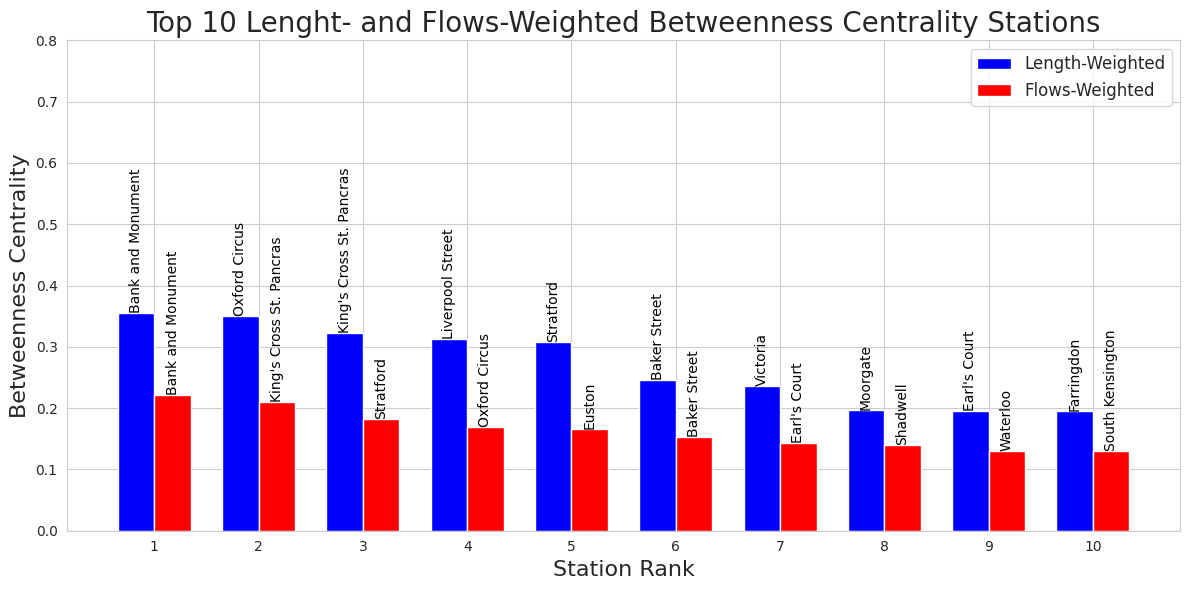

In [28]:
# Sort the dataframes by score in descending order
df_unweighted_sorted = df_betwn_flows_top20.sort_values(by='betweenness', ascending=False).head(10)
df_weighted_sorted = df_betwn_length_top20.sort_values(by='betweenness', ascending=False).head(10)

# Define the width of each bar
bar_width = 0.35

plt.figure(figsize=(12, 6))

# Plot unweighted data
unweighted_bars = plt.bar(np.arange(len(df_unweighted_sorted)), df_unweighted_sorted['betweenness'], bar_width, color='blue', label='Length-Weighted')

# Plot weighted data
weighted_bars = plt.bar(np.arange(len(df_weighted_sorted)) + bar_width, df_weighted_sorted['betweenness'], bar_width, color='red', label='Flows-Weighted')

# Add station names as labels
for bar, station in zip(unweighted_bars, df_unweighted_sorted['Station']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), station, ha='center', va='bottom', rotation=90, fontsize=10, color='black')

for bar, station in zip(weighted_bars, df_weighted_sorted['Station']):
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), station, ha='center', va='bottom', rotation=90, fontsize=10, color='black')

# Set labels and title
plt.xlabel('Station Rank', fontsize=16)
plt.ylabel('Betweenness Centrality', fontsize=16)
plt.title('Top 10 Lenght- and Flows-Weighted Betweenness Centrality Stations', fontsize=20)
plt.xticks(np.arange(10) + bar_width / 2, range(1, 11))  # Display only the top 10 ranks
plt.yticks(np.arange(0, 0.9, 0.1))  # Extend y-axis to 0.7 with intervals of 0.1

# Enlarge legend font size
plt.legend(fontsize='large')

plt.tight_layout()
plt.savefig('betweenness_comparisons2.png', dpi=300)
plt.show()

## Alternative impact measure with flows

In [37]:
def weighted_global_efficiency(G):

    def single_node_efficiency(node):
        shortest_paths = nx.single_source_dijkstra_path_length(G, node, weight='inv_flows')
        total_efficiency = 0
        for target, distance in shortest_paths.items():
            if distance != 0:
                total_efficiency += 1 / distance
        return total_efficiency / (len(G) - 1)

    total_efficiency = 0
    num_pairs = 0
    for u in G.nodes():
      for v in G.nodes():
        if u != v:
          total_efficiency += single_node_efficiency(u) + single_node_efficiency(v)
          num_pairs += 1

    total_possible_weighted_sum = num_pairs * (len(G) - 1)

    return total_efficiency / total_possible_weighted_sum
weighted_global_efficiency(G)

13.574916355027796

In [30]:
weig_global_eff2 = weighted_global_efficiency(G)
print("Normalized Efficiency:", weig_global_eff2)

Normalized Efficiency: 13.574916355027796


## Node removal

In [42]:
# function to calculate impact measures (global efficiency and weighted global efficiecny) from a graph G
def evaluate_impact_weighted(G):
  global_eff = nx.global_efficiency(G)
  wglobal_eff = weighted_global_efficiency(G)

  return global_eff, wglobal_eff

In [32]:
# Removal of top 3 nodes from the flow weighted betweenness centrality and impact assessement with average path and global efficiency
columns = ['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure']
df_rm_flowbetcen_nonweiimp = pd.DataFrame(columns=columns)

base_AvgPathLength, base_global_eff = evaluate_impact(G)
df_rm_flowbetcen_nonweiimp.loc[0] = [0, 'NA', base_AvgPathLength, base_global_eff, 'sequential', 'betweenness-flows']

df_betw_cen = pd.DataFrame.from_dict(G_betwn_flows_cen, columns=['betweenness_invflows'], orient='index')
df_betw_cen = df_betw_cen.sort_values(by='betweenness_invflows', ascending=False)

G_seq = G.copy()

for i in range(3):
  G_betwn_cen = nx.betweenness_centrality(G_seq, weight='inv_flows', normalized=True)
  nx.set_node_attributes(G_seq, G_betwn_cen, 'betweenness_invflows')

  df = pd.DataFrame(index=G_seq.nodes())
  df['betweenness_invflows'] = pd.Series(nx.get_node_attributes(G_seq, 'betweenness_invflows'))
  df_sorted = df.sort_values(['betweenness_invflows'], ascending=False)
  row = df_sorted.head(1)
  removed_station = row.index[0]
  G_seq.remove_node(removed_station)

  avg_path_length, global_eff = evaluate_impact(G_seq)

  new_row = pd.DataFrame([[i+1, removed_station, avg_path_length, global_eff, 'sequential', 'betweenness-flows']], columns=['nodesRemoved', 'stationRemoved', 'AvgPathLength', 'GlobalEfficiency', 'Method', 'CentralityMeasure'])
  df_rm_flowbetcen_nonweiimp = pd.concat([df_rm_flowbetcen_nonweiimp, new_row], ignore_index=True)

df_rm_flowbetcen_nonweiimp.head(10)

,nodesRemoved,stationRemoved,AvgPathLength,GlobalEfficiency,Method,CentralityMeasure
0,0,NA,20099.721573,0.101256,sequential,betweenness-flows
1,1,Bank and Monument,20423.399394,0.096735,sequential,betweenness-flows
2,2,Oxford Circus,20546.922999,0.095722,sequential,betweenness-flows
3,3,King's Cross St. Pancras,21841.245396,0.088433,sequential,betweenness-flows


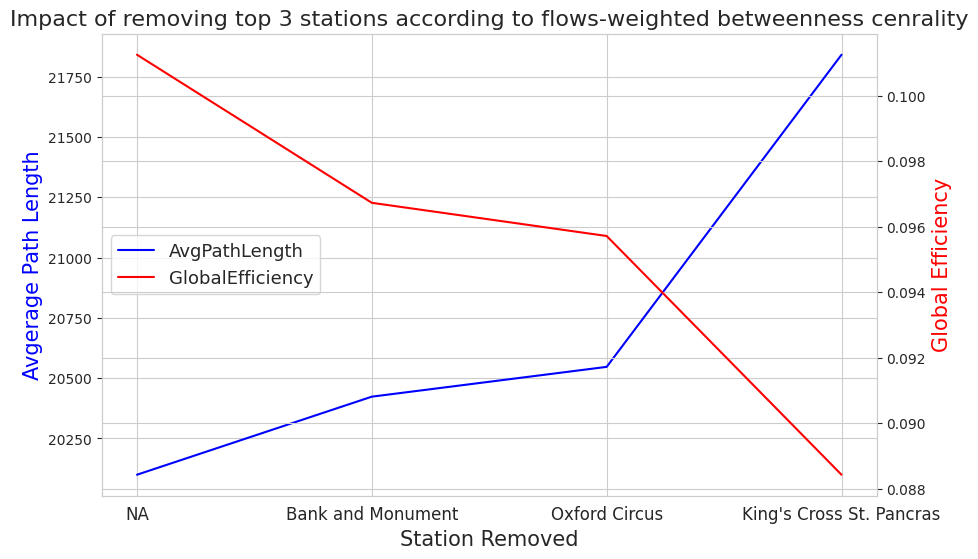

In [33]:
df = df_rm_flowbetcen_nonweiimp

df_sorted = df.sort_values(by='nodesRemoved')
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot AvgPathLength on the primary y-axis
ax1.plot(df_sorted['nodesRemoved'], df_sorted['AvgPathLength'], label='AvgPathLength', color='blue')
ax1.set_xlabel('Station Removed', fontsize=15)
ax1.set_ylabel('Avgerage Path Length', color='blue', fontsize=15)

# Create a secondary y-axis for GlobalEfficiency
ax2 = ax1.twinx()
ax2.plot(df_sorted['nodesRemoved'], df_sorted['GlobalEfficiency'], label='GlobalEfficiency', color='red')
ax2.set_ylabel('Global Efficiency', color='red', fontsize=15)

# Set x-axis labels as stationRemoved
ax1.set_xticks(df_sorted['nodesRemoved'])
ax1.set_xticklabels(df_sorted['stationRemoved'], rotation=0, fontsize=12)

# Show legend on the left side (centered)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center left', fontsize=13)

# Show plot
plt.title('Impact of removing top 3 stations according to flows-weighted betweenness cenrality', fontsize=16)
plt.savefig('noderemoval3_unweighted.png', dpi=300)

plt.show()

In [34]:
# Removal of top 3 nodes from the flow weighted betweenness centrality using the flow weighted global efficiiency
columns = ['nodesRemoved', 'stationRemoved', 'GlobalEfficiency', 'WeightedGlobalEfficiency', 'Method', 'CentralityMeasure']
df_rm_flowbetcen = pd.DataFrame(columns=columns)

base_AvgPathLength, base_global_eff = evaluate_impact_weighted(G)
df_rm_flowbetcen.loc[0] = [0, 'NA', base_AvgPathLength, base_global_eff, 'sequential', 'betweenness-flows']

df_betw_cen = pd.DataFrame.from_dict(G_betwn_flows_cen, columns=['betweenness_invflows'], orient='index')
df_betw_cen = df_betw_cen.sort_values(by='betweenness_invflows', ascending=False)

G_seq = G.copy()

for i in range(3):
  G_betwn_cen = nx.betweenness_centrality(G_seq, weight='inv_flows', normalized=True)
  nx.set_node_attributes(G_seq, G_betwn_cen, 'betweenness_invflows')

  df = pd.DataFrame(index=G_seq.nodes())
  df['betweenness_invflows'] = pd.Series(nx.get_node_attributes(G_seq, 'betweenness_invflows'))
  df_sorted = df.sort_values(['betweenness_invflows'], ascending=False)
  row = df_sorted.head(1)
  removed_station = row.index[0]
  G_seq.remove_node(removed_station)

  avg_path_length, global_eff = evaluate_impact_weighted(G_seq)

  new_row = pd.DataFrame([[i+1, removed_station, avg_path_length, global_eff, 'sequential', 'betweenness-flows']], columns=['nodesRemoved', 'stationRemoved', 'GlobalEfficiency', 'WeightedGlobalEfficiency', 'Method', 'CentralityMeasure'])
  df_rm_flowbetcen = pd.concat([df_rm_flowbetcen, new_row], ignore_index=True)

df_rm_flowbetcen.head(10)

,nodesRemoved,stationRemoved,GlobalEfficiency,WeightedGlobalEfficiency,Method,CentralityMeasure
0,0,NA,0.101256,13.574916,sequential,betweenness-flows
1,1,Bank and Monument,0.096735,12.675357,sequential,betweenness-flows
2,2,Oxford Circus,0.095722,11.049988,sequential,betweenness-flows
3,3,King's Cross St. Pancras,0.088433,8.842160,sequential,betweenness-flows


In [40]:
df_rm_flowbetcen['AvgPathLength'] = df_rm_flowbetcen_nonweiimp['AvgPathLength']
df_rm_flowbetcen

,nodesRemoved,stationRemoved,GlobalEfficiency,WeightedGlobalEfficiency,Method,CentralityMeasure,AvgPathLength
0,0,NA,0.101256,13.574916,sequential,betweenness-flows,20099.721573
1,1,Bank and Monument,0.096735,12.675357,sequential,betweenness-flows,20423.399394
2,2,Oxford Circus,0.095722,11.049988,sequential,betweenness-flows,20546.922999
3,3,King's Cross St. Pancras,0.088433,8.842160,sequential,betweenness-flows,21841.245396


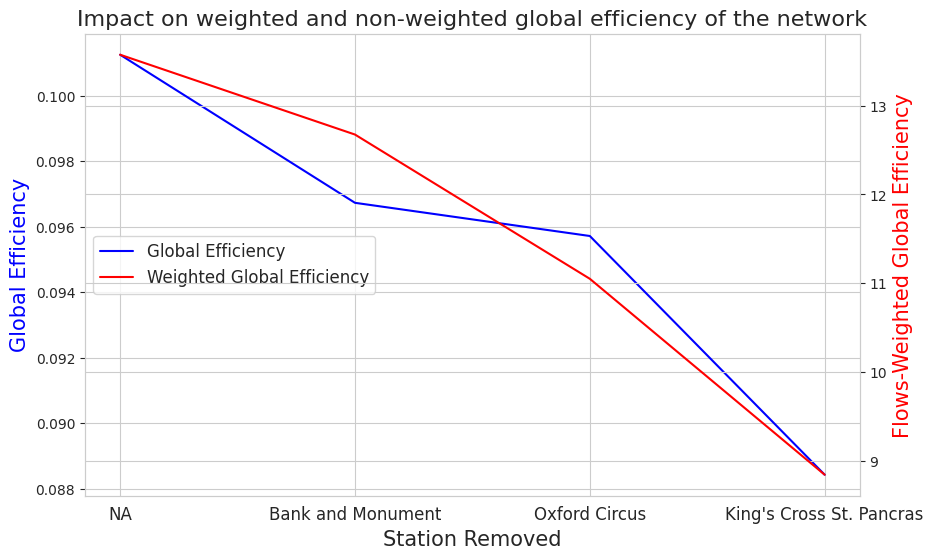

In [43]:
df = df_rm_flowbetcen

df_sorted = df.sort_values(by='nodesRemoved')
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot AvgPathLength on the primary y-axis
ax1.plot(df_sorted['nodesRemoved'], df_sorted['GlobalEfficiency'], label='Global Efficiency', color='blue')
ax1.set_xlabel('Station Removed', fontsize=15)
ax1.set_ylabel('Global Efficiency', color='blue', fontsize=15)

# Create a secondary y-axis for GlobalEfficiency
ax2 = ax1.twinx()
ax2.plot(df_sorted['nodesRemoved'], df_sorted['WeightedGlobalEfficiency'], label='Weighted Global Efficiency', color='red')
ax2.set_ylabel('Flows-Weighted Global Efficiency', color='red', fontsize=15)

# Set x-axis labels as stationRemoved
ax1.set_xticks(df_sorted['nodesRemoved'])
ax1.set_xticklabels(df_sorted['stationRemoved'], rotation=0, fontsize=12)

# Show legend on the left side (centered)
lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='center left', fontsize=12)

# Show plot
plt.title('Impact on weighted and non-weighted global efficiency of the network', fontsize=16)
plt.savefig('noderemoval3_weighted.png', dpi=300)

plt.show()